# 2. Potential sites of chemical modification

An initial scan of the antibody sequences is presented based purely upon sequence. If a
structural analysis was also requested, this section should be used in conjunction with the
molecular surface analysis described in a subsequent section. Any of the sites listed below
could be candidates for further consideration if the molecular surface analysis shows that they
are significantly exposed on the surface of the antibody, increasing their propensity for chemical
modification. The canonical sequence analysis is also helpful here, since each of these sites
can also be considered in the context of their frequency of occurrence within the canonical
library of homologous sequences.

## tryptophan and methionine residues in CDRs

The indole ring of Tryptophan (W) is prone to oxidation, especially when exposed to UV.
Tryptophan residues in exposed positions in the CDRs, can affect the solubility of an antibody
and lead to non-specific antigen binding.
Methionine (M) residues are prone to oxidation through the formation of a sulfoxide, and can
also become irreversibly oxidized. This oxidation can be accelerated by exposure to metal ions
(e.g. from the wall of a stainless steel fermentation vessel).


In [20]:
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils.ProtParam import ProtParamData
record = SeqIO.read("../data/sequence.fasta", "fasta")
my_seq = str(record.seq)
analyzed_seq = ProteinAnalysis(my_seq)

## potential deamidation positions

Asparagine (N) and glutamine (Q) residues are particularly prone to deamidation when they are
followed in the sequence by amino acids with smaller side chains, that leave the intervening
peptide group more exposed. Deamidation proceeds much more quickly if the susceptible
amino acid is followed by a small, flexible residue such as glycine whose low steric hindrance leaves the peptide group open for attack.


Search patterns: ASN/GLN-ALA/GLY/SER/THR

In [64]:
import re

deamidation_pattern = '(N|Q)(A|G|S|T)'

match = re.finditer(deamidation_pattern, my_seq)    

if re.search(deamidation_pattern, my_seq):
    for i in match:
        print(i.start())
        print(i.end())
        #print(i.span())
        print(i.group())
else:
    print('there is no deamination pattern')

67
69
NA
83
85
NG
96
98
QT
98
100
NT
157
159
QS
179
181
QG
195
197
NS
270
272
NA
281
283
NS
299
301
NG
368
370
NG
403
405
QG


## potential o-linked glycosylation sites

The O-linked glycosylation of serine and threonine residues seems to be particularly sensitive to
the presence of one or more proline residues in their vicinity in the sequence, particularly in the2
-1 and +3 positions.


Search patterns: PRO-SER/THR, SER/THR-X-X-PRO

In [66]:
o_glycosylation_pattern = 'P(S|T)'

match = re.finditer(o_glycosylation_pattern, my_seq)    

if re.search(o_glycosylation_pattern, my_seq):
    for i in match:
        print(i.start())
        print(i.end())
        #print(i.span())
        print(i.group())
else:
    print('there is no o-linked glycosylation pattern')

107
109
PS
140
142
PS
222
224
PS
337
339
PS
358
360
PS


In [68]:
o_glycosylation_pattern = '(S|T)[A-Z]{2}P'

match = re.finditer(o_glycosylation_pattern, my_seq)    

if re.search(o_glycosylation_pattern, my_seq):
    for i in match:
        print(i.start())
        print(i.end())
        #print(i.span())
        print(i.group())
else:
    print('there is no o-linked glycosylation pattern')

2
6
TGRP
11
15
SEIP
47
51
TLIP
209
213
TCPP
238
242
SRTP
334
338
TLPP
377
381
TTPP
426
430
SLSP


## potential n-linked glycosylation sites
Search patterns: ASN-X-SER/THR

In [69]:
import re

N_glycosylation_pattern = 'N[A-Z][S|T]'
# N_glycosylation_pattern = 'N[^P][ST][^P]'
# putting a caret ^ at the start of the group will negate it
# and match any character that is not in that group

if re.search(N_glycosylation_pattern, my_seq):
    print("N-glycosylation site motif found")
else:
    print("No motif found")

match = re.finditer(N_glycosylation_pattern, Protein_seq)    

for i in match:
    print(i.start())
    print(i.end())
#     print(i.span())
    print(i.group())

N-glycosylation site motif found
35
38
NIT
67
70
NAT
122
125
NCT
195
198
NST
281
284
NST


## Secondary structure prediction


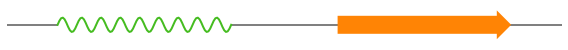

In [8]:
# Code source: Patrick Kunzmann
# License: BSD 3 clause

from tempfile import gettempdir
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import biotite
import biotite.structure as struc
import biotite.structure.io.mmtf as mmtf
import biotite.sequence as seq
import biotite.sequence.graphics as graphics
import biotite.sequence.io.genbank as gb
import biotite.database.rcsb as rcsb
import biotite.database.entrez as entrez
import biotite.application.dssp as dssp


# Create 'FeaturePlotter' subclasses
# for drawing the scondary structure features

class HelixPlotter(graphics.FeaturePlotter):

    def __init__(self):
        pass

    # Check whether this class is applicable for drawing a feature
    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "helix":
                    return True
        return False

    # The drawing function itself
    def draw(self, axes, feature, bbox, loc, style_param):
        # Approx. 1 turn per 3.6 residues to resemble natural helix
        n_turns = np.ceil((loc.last - loc.first + 1) / 3.6)
        x_val = np.linspace(0, n_turns * 2*np.pi, 100)
        # Curve ranges from 0.3 to 0.7
        y_val = (-0.4*np.sin(x_val) + 1) / 2

        # Transform values for correct location in feature map
        x_val *= bbox.width / (n_turns * 2*np.pi)
        x_val += bbox.x0
        y_val *= bbox.height
        y_val += bbox.y0

        # Draw white background to overlay the guiding line
        background = Rectangle(
            bbox.p0, bbox.width, bbox.height, color="white", linewidth=0
        )
        axes.add_patch(background)
        axes.plot(
            x_val, y_val, linewidth=2, color=biotite.colors["dimgreen"]
        )


class SheetPlotter(graphics.FeaturePlotter):

    def __init__(self, head_width=0.8, tail_width=0.5):
        self._head_width = head_width
        self._tail_width = tail_width


    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "sheet":
                    return True
        return False

    def draw(self, axes, feature, bbox, loc, style_param):
        x = bbox.x0
        y = bbox.y0 + bbox.height/2
        dx = bbox.width
        dy = 0

        if  loc.defect & seq.Location.Defect.MISS_RIGHT:
            # If the feature extends into the prevoius or next line
            # do not draw an arrow head
            draw_head = False
        else:
            draw_head = True

        axes.add_patch(biotite.AdaptiveFancyArrow(
            x, y, dx, dy,
            self._tail_width*bbox.height, self._head_width*bbox.height,
            # Create head with 90 degrees tip
            # -> head width/length ratio = 1/2
            head_ratio=0.5, draw_head=draw_head,
            color=biotite.colors["orange"], linewidth=0
        ))


# Test our drawing functions with example annotation
annotation = seq.Annotation([
    seq.Feature("SecStr", [seq.Location(10, 40)], {"sec_str_type" : "helix"}),
    seq.Feature("SecStr", [seq.Location(60, 90)], {"sec_str_type" : "sheet"}),
])

fig = plt.figure(figsize=(8.0, 0.8))
ax = fig.add_subplot(111)
graphics.plot_feature_map(
    ax, annotation, multi_line=False, loc_range=(1,100),
    # Register our drawing functions
    feature_plotters=[HelixPlotter(), SheetPlotter()]
)
fig.tight_layout()

In [3]:
from Bio import SeqIO

record = SeqIO.read("../data/sequence.fasta", "fasta")
print(record)

ID: Aflibercept
Name: Aflibercept
Description: Aflibercept
Number of features: 0
Seq('SDTGRPFVEMYSEIPEIIHMTEGRELVIPCRVTSPNITVTLKKFPLDTLIPDGK...SPG')


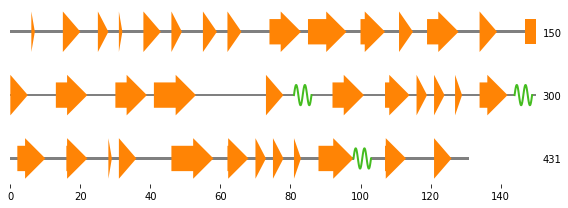

In [18]:
import biotite.structure as struc
import biotite.structure.io.pdb as pdb
import biotite.sequence as seq

# Dictionary to convert 'secStructList' codes to DSSP values
# https://github.com/rcsb/mmtf/blob/master/spec.md#secstructlist
sec_struct_codes = {0 : "I",
                    1 : "S",
                    2 : "H",
                    3 : "E",
                    4 : "G",
                    5 : "B",
                    6 : "T",
                    7 : "C"}
# Converter for the DSSP secondary structure elements
# to the classical ones
dssp_to_abc = {"I" : "c",
               "S" : "c",
               "H" : "a",
               "E" : "b",
               "G" : "c",
               "B" : "b",
               "T" : "c",
               "C" : "c"}


# Helper function to convert secondary structure array to annotation
# and visualize it
def visualize_secondary_structure(sse, first_id):

    def _add_sec_str(annotation, first, last, str_type):
        if str_type == "a":
            str_type = "helix"
        elif str_type == "b":
            str_type = "sheet"
        else:
            # coil
            return
        feature = seq.Feature(
            "SecStr", [seq.Location(first, last)], {"sec_str_type" : str_type}
        )
        annotation.add_feature(feature)

    # Find the intervals for each secondary structure element
    # and add to annotation
    annotation = seq.Annotation()
    curr_sse = None
    curr_start = None
    for i in range(len(sse)):
        if curr_start is None:
            curr_start = i
            curr_sse = sse[i]
        else:
            if sse[i] != sse[i-1]:
                _add_sec_str(
                    annotation, curr_start+first_id, i-1+first_id, curr_sse
                )
                curr_start = i
                curr_sse = sse[i]
    # Add last secondary structure element to annotation
    _add_sec_str(annotation, curr_start+first_id, i-1+first_id, curr_sse)

    fig = plt.figure(figsize=(8.0, 3.0))
    ax = fig.add_subplot(111)
    graphics.plot_feature_map(
        ax, annotation, symbols_per_line=150,
        loc_range=(first_id, first_id+len(sse)),
        show_numbers=True, show_line_position=True,
        feature_plotters=[HelixPlotter(), SheetPlotter()]
    )
    fig.tight_layout()


# Fetch and load structure
# file_name = rcsb.fetch("1QGD", "mmtf", gettempdir())
file_name = rcsb.fetch("1QGD", "mmtf", gettempdir())

mmtf_file = mmtf.MMTFFile.read(file_name)
pdb_file = pdb.PDBFile.read("../data/predict_aflibercept.pdb")
# array = mmtf.get_structure(mmtf_file, model=1)
array = pdb_file.get_structure(model=1)
# Transketolase homodimer
tk_dimer = array[struc.filter_amino_acids(array)]
# Transketolase monomer
tk_mono = tk_dimer[tk_dimer.chain_id == "A"]

# The chain ID corresponding to each residue
# chain_id_per_res = array.chain_id[struc.get_residue_starts(tk_dimer)]

# Visualize seconday structure array
# Sine the residues may not start at 1,
# provide the actual first residue ID

sse = dssp.DsspApp.annotate_sse(tk_mono)
sse = np.array([dssp_to_abc[e] for e in sse], dtype="U1")
visualize_secondary_structure(sse, tk_mono.res_id[0])


## protein_scale

    Compute a profile by any amino acid scale.

    An amino acid scale is defined by a numerical value assigned to each type of amino acid. The most frequently used scales are the hydrophobicity or hydrophilicity scales and the secondary structure conformational parameters scales, but many other scales exist which are based on different chemical and physical properties of the amino acids. You can set several parameters that control the computation of a scale profile, such as the window size and the window edge relative weight value.

    WindowSize: The window size is the length of the interval to use for the profile computation. For a window size n, we use the i-(n-1)/2 neighboring residues on each side to compute the score for residue i. The score for residue i is the sum of the scaled values for these amino acids, optionally weighted according to their position in the window.

    Edge: The central amino acid of the window always has a weight of 1. By default, the amino acids at the remaining window positions have the same weight, but you can make the residue at the center of the window have a larger weight than the others by setting the edge value for the residues at the beginning and end of the interval to a value between 0 and 1. For instance, for Edge=0.4 and a window size of 5 the weights will be: 0.4, 0.7, 1.0, 0.7, 0.4.

    The method returns a list of values which can be plotted to view the change along a protein sequence. Many scales exist. Just add your favorites to the ProtParamData modules.

    Similar to expasy’s ProtScale: http://www.expasy.org/cgi-bin/protscale.pl


In [47]:
analyzed_seq = ProteinAnalysis(my_seq)
data = analyzed_seq.protein_scale(window=7, param_dict=ProtParamData.kd)

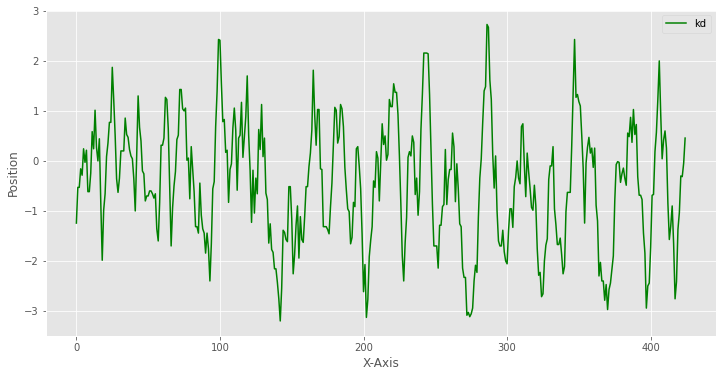

In [49]:
plt.figure(figsize=(12,6))
plt.style.use('ggplot')

data = analyzed_seq.protein_scale(window=7, param_dict=ProtParamData.kd)
plt.plot(data, label='Hydrophobicity', color='g')
plt.xlabel('X-Axis')
plt.ylabel('Position')
plt.legend()
plt.show()

gravy_scales = {"KyteDoolitle": kd, "Aboderin": ab,
                "AbrahamLeo": al, "Argos": ag,
                "BlackMould": bm, "BullBreese": bb,
                "Casari": cs, "Cid": ci,
                "Cowan3.4": cw[3.4], "Cowan7.5": cw[7.5],
                "Eisenberg": es, "Engelman": eg,
                "Fasman": fs, "Fauchere": fc,
                "GoldSack": gd, "Guy": gy,
                "Jones": jo, "Juretic": ju,
                "Kidera": ki, "Miyazawa": mi,
                "Parker": pa, "Ponnuswamy": po,
                "Rose": ro, "Roseman": rm,
                "Sweet": sw, "Tanford": ta,
                "Wilson": wi, "Zimmerman": zi}

전부 겹쳐서 그리는게 좋을 것 같다

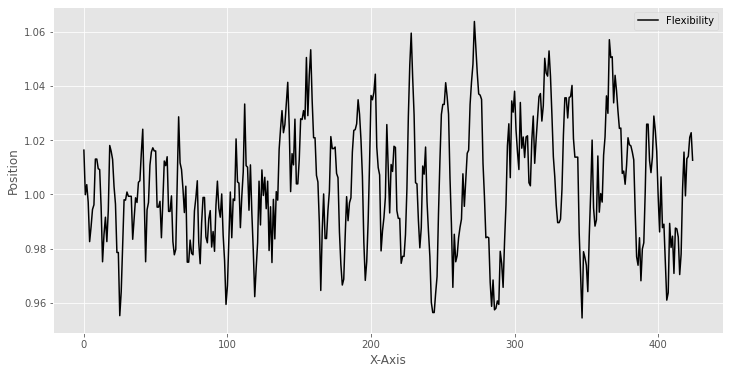

In [52]:
plt.figure(figsize=(12,6))
plt.style.use('ggplot')

data = analyzed_seq.protein_scale(window=7, param_dict=ProtParamData.Flex)
plt.plot(data, label='Flexibility', color='k')
plt.xlabel('X-Axis')
plt.ylabel('Position')
plt.legend()
plt.show()

```

# Flexibility
# Normalized flexibility parameters (B-values), average
# Vihinen M., Torkkila E., Riikonen P. Proteins. 19(2):141-9(1994).
Flex = {"A": 0.984, "C": 0.906, "E": 1.094, "D": 1.068,
        "G": 1.031, "F": 0.915, "I": 0.927, "H": 0.950,
        "K": 1.102, "M": 0.952, "L": 0.935, "N": 1.048,
        "Q": 1.037, "P": 1.049, "S": 1.046, "R": 1.008,
        "T": 0.997, "W": 0.904, "V": 0.931, "Y": 0.929}
```
        
이것도 전부 겹쳐서 그려보자

https://github.com/biopython/biopython/blob/master/Bio/SeqUtils/ProtParamData.py

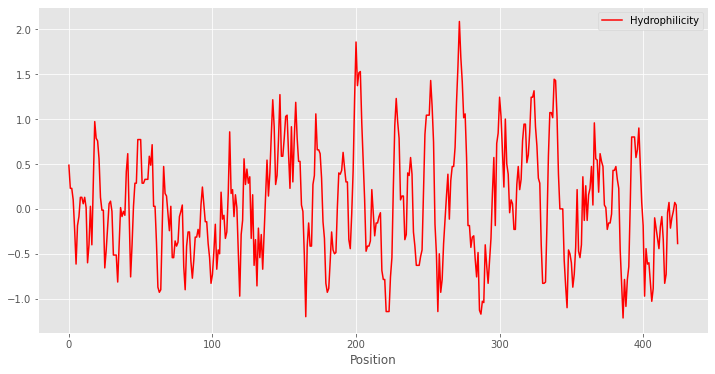

In [55]:
plt.figure(figsize=(12,6))
plt.style.use('ggplot')

data = analyzed_seq.protein_scale(window=7, param_dict=ProtParamData.hw)
plt.plot(data, label='Hydrophilicity', color='r')
plt.xlabel('Position')
plt.ylabel('')
plt.legend()
plt.show()

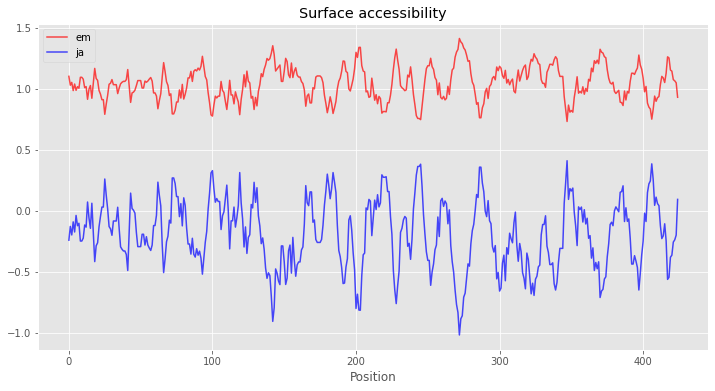

In [56]:
# Surface accessibility
# Vergoten G & Theophanides T, Biomolecular Structure and Dynamics,
# pg.138 (1997).
# 1 Emini Surface fractional probability
em = {"A": 0.815, "R": 1.475, "N": 1.296, "D": 1.283, "C": 0.394,
      "Q": 1.348, "E": 1.445, "G": 0.714, "H": 1.180, "I": 0.603,
      "L": 0.603, "K": 1.545, "M": 0.714, "F": 0.695, "P": 1.236,
      "S": 1.115, "T": 1.184, "W": 0.808, "Y": 1.089, "V": 0.606}

# 2 Janin Interior to surface transfer energy scale
ja = {"A": 0.28, "R": -1.14, "N": -0.55, "D": -0.52, "C": 0.97,
      "Q": -0.69, "E": -1.01, "G": 0.43, "H": -0.31, "I": 0.60,
      "L": 0.60, "K": -1.62, "M": 0.43, "F": 0.46, "P": -0.42,
      "S": -0.19, "T": -0.32, "W": 0.29, "Y": -0.15, "V": 0.60}

plt.figure(figsize=(12,6))
plt.style.use('ggplot')

data = analyzed_seq.protein_scale(window=7, param_dict=ProtParamData.em)
plt.plot(data, label='em', color='r', alpha=0.7)
data = analyzed_seq.protein_scale(window=7, param_dict=ProtParamData.ja)
plt.plot(data, label='ja', color='b', alpha=0.7)

plt.title('Surface accessibility')
plt.xlabel('Position')
plt.ylabel('')
plt.legend()
plt.show()

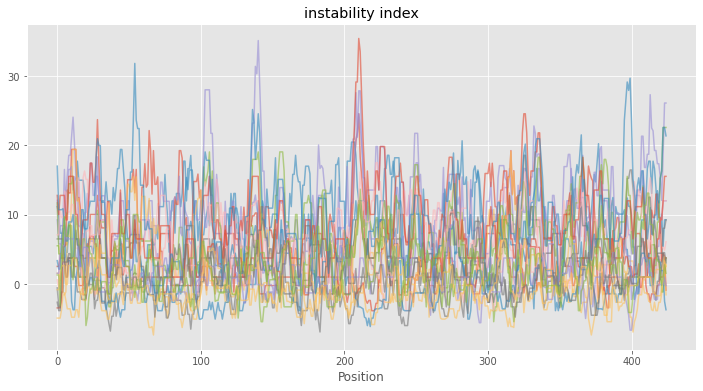

In [63]:
plt.figure(figsize=(12,6))
plt.style.use('ggplot')

DIWV_list = list('ACEDGFIHKMLNQPSRTWVY')

for i in DIWV_list:
    data = analyzed_seq.protein_scale(window=7, param_dict=ProtParamData.DIWV[i])
    plt.plot(data, alpha=0.6)

plt.title('instability index')
plt.xlabel('Position')
plt.ylabel('')
# plt.legend()
plt.show()